### Imports

In [1]:
!pip install transformers
!pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.5 MB/s 
     |████████████████████████████████| 7.6 MB 52.7 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 8.6 MB/s 


In [2]:
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch import nn

import transformers
# from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# from transformers import XLNetModel, XLNetTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import ElectraModel, ElectraTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score , confusion_matrix

RANDOM_SEED=30
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if(torch.cuda.is_available()):
    torch.cuda.empty_cache()
    gc.collect()


### Hyperparameters

In [3]:
BATCH_SIZE = 16
MAX_LEN = 256
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
path='drive/MyDrive/NLP_Sem_5/NLP_Project/report_material/'

In [6]:
def create_dataframes(stopwords=False, oversampling=0, augmented=False):
    if(stopwords and augmented):
        df_train=pd.read_csv(path+'train_augmented_with_stopwords.csv')
        df_val=pd.read_csv(path+'val_with_stopwords.csv')
    elif(stopwords and (not augmented)):
        df_train=pd.read_csv(path+'train_new_with_stopwords.csv')
        df_val=pd.read_csv(path+'val_with_stopwords.csv')
        
    elif((not stopwords) and augmented):
        df_train=pd.read_csv(path+'train_augmented_without_stopwords.csv')
        df_val=pd.read_csv(path+'val_without_stopwords.csv')
    
    elif((not stopwords) and (not augmented)):
        df_train=pd.read_csv(path+'train_new_without_stopwords.csv')
        df_val=pd.read_csv(path+'val_without_stopwords.csv')
        
    df_train_0=df_train.loc[df_train['label']==0]
    for i in range(oversampling):
        df_train=df_train.append(df_train_0, ignore_index=True)
        
    return df_train, df_val


df_train, df_val=create_dataframes(oversampling = 2)
print(df_train.shape)
print(df_val.shape)

(17630, 3)
(3966, 3)


In [7]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Creating Dataset and Model

In [8]:
class TweetDataset(Dataset):

    def __init__(self, tweets, labels, tokenizer, max_len, transform = None):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
  
    def __len__(self):
        return len(self.tweets)
  
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True,
        )
        sample = {
        'text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype=torch.long)
        }
        if(self.transform):
            sample = self.transform(sample)
        return sample
        
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(
    tweets=df['tweet'].to_numpy(),
    labels=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size,
    sampler=RandomSampler(ds),
    num_workers=8
    )
    

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

class TestDataset(Dataset):

    def __init__(self, tweets, index, tokenizer, max_len, transform = None):
        self.tweets = tweets
        self.index = index
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
  
    def __len__(self):
        return len(self.tweets)
  
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        index = self.index[item]
        encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True,
        )
        sample = {
        'text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'index': index
        }
        if(self.transform):
            sample = self.transform(sample)
        return sample

def create_test_loader(df, tokenizer, max_len, batch_size):
    ds = TestDataset(
    tweets=df['tweet'].to_numpy(),
    index=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
    )
    
# data=next(iter(train_data_loader))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
class HateSpeechClassifier(nn.Module):

    def __init__(self, n_classes, lm):
        super(HateSpeechClassifier, self).__init__()
        self.lm = lm
        self.drop = nn.Dropout(p=0.2)
        # print(self.lm.config.hidden_size)
        self.out = nn.Sequential(
            nn.Linear(self.lm.config.hidden_size, 256),
            nn.Tanh(),
            # nn.Linear(512,256),
            # nn.ReLU(),
            nn.Linear(256, 64), 
            nn.Tanh(),
            nn.Linear(64, n_classes),
            # nn.Softmax(n_classes),
        )
  
    def forward(self, input_ids, attention_mask):
        bert_output = self.lm(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.drop(bert_output[1])
        return self.out(output)

In [10]:
model = HateSpeechClassifier(n_classes=3, lm = bert_model)
model = model.to(device)

In [ ]:
for param in bert_model.base_model.parameters():
    print(param.requires_grad)

### Training

In [12]:
EPOCHS = 5

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, eps=1e-9)
total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, 
    num_training_steps=total_steps
)

loss_func = nn.CrossEntropyLoss().to(device)

In [13]:
def train_epoch(
    model,
    data_loader, 
    loss_func, 
    optimizer, 
    device, 
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)
        
        output = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        
        _, prediction = torch.max(output, dim=1)
        loss = loss_func(output, labels)
        
        correct_predictions += torch.sum(prediction == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double() / n_examples, np.mean(losses)


def val_epoch(
    model,
    data_loader, 
    device,
):
    p=[]
    y_true=[]
    model.eval()
    with torch.no_grad():
        for d in data_loader:
            output = model(
                input_ids=d['input_ids'].to(device),
                attention_mask=d['attention_mask'].to(device),
            )
            y_true+=(d['label'].tolist())
            _, prediction=torch.max(output, dim=1)
            p+=prediction.tolist()
        
        
    prediction=np.array(p)
    y_true=np.array(y_true)
    
    accuracy=accuracy_score(y_true, prediction)
    macro_f1_score=f1_score(y_true, prediction, average='macro')
    confusion_matrix_calc = confusion_matrix(y_true, prediction)
    
    return accuracy, macro_f1_score, confusion_matrix_calc


In [14]:
best_epoch=0
best_score=0
for i in range(EPOCHS):
    print("Epoch: ", i)
    train_accuracy, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_func,
        optimizer,
        device,
        scheduler, 
        len(df_train)
    )
    # print("Accuracy: "+ str(train_accuracy.item()) + "\tLoss: "+str(train_loss))
    
    val_accuracy, val_f1_score,val_confusionmatrix =val_epoch(model=model, data_loader=val_data_loader, device=device)
    print("Val accuracy: "+str(val_accuracy)+"\tVal f1_score: "+str(val_f1_score))
    if(val_f1_score>best_score):
        best_epoch=i
        best_score=val_f1_score
        best_accuracy=val_accuracy
        best_confusion_matrix = val_confusionmatrix
        torch.save(model.state_dict(),'./roberta-ffn-o2.pt')
    
print("Ideal number of epochs: ", best_epoch+1)
print("BEST Confsuion Matrix" , best_confusion_matrix)

best_epoch+=1


Epoch:  0
Val accuracy: 0.8835098335854765	Val f1_score: 0.7509155501868127
Epoch:  1


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val accuracy: 0.8991427130610187	Val f1_score: 0.7673964243807935
Epoch:  2


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val accuracy: 0.8940998487140696	Val f1_score: 0.7633325495484652
Epoch:  3


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val accuracy: 0.8915784165405951	Val f1_score: 0.7569665490925751
Epoch:  4


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Val accuracy: 0.8867876954109934	Val f1_score: 0.7565855034887162
Ideal number of epochs:  2
BEST Confsuion Matrix [[ 133   93   26]
 [ 142 2864   74]
 [  19   46  569]]


In [15]:
df_test = pd.read_csv('drive/MyDrive/NLP_Sem_5/NLP_Project/'+'test_without_stopwords.csv')
test_data_loader = create_test_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
model = HateSpeechClassifier(n_classes=3, lm = bert_model)
model.load_state_dict(torch.load('./roberta-ffn-o2.pt'))
model = model.to(device)

In [17]:
p=[]
index_list=[]
model.eval()
for d in test_data_loader:
    
    output = model(
        input_ids=d['input_ids'].to(device),
        attention_mask=d['attention_mask'].to(device),
    )
    index_list+=(d['index'].tolist())
    _, prediction=torch.max(output, dim=1)
    
    p+=prediction.tolist()

In [18]:
output_df=pd.DataFrame(columns=['label', 'id'])
output_df['label']=p
output_df['id']=index_list

output_df.sort_values(by=['id'])

,label,id
0,0,0
1,0,1
2,1,2
3,1,3
4,1,4
...,...,...
4952,0,4952
4953,2,4953
4954,2,4954
4955,2,4955


In [19]:
output_df.to_csv('drive/MyDrive/NLP_Sem_5/NLP_Project/'+"roberta-ffn-o2-outputs.csv", index=False, encoding='utf-8-sig')

In [ ]:
import seaborn as sns

Ideal number of epochs:  4
Best Score  0.7488253860672677
Best accuracy  0.8951084215834594
Best Confsuion Matrix : 
  [[ 105  126   21]
 [  86 2879  115]
 [  12   56  566]]


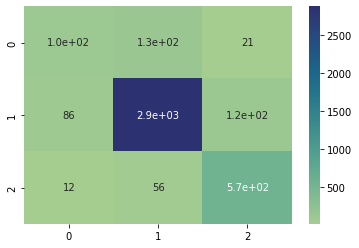

In [ ]:
print("Ideal number of epochs: ", best_epoch)
print("Best Score " , best_score)
print("Best accuracy " , best_accuracy )
print("Best Confsuion Matrix : \n " , best_confusion_matrix)
sns.heatmap(best_confusion_matrix, annot=True, cmap='crest')

In [ ]:
torch.cuda.empty_cache()
gc.collect()

94

In [ ]:
class TestDataset(Dataset):

    def __init__(self, tweets, index, tokenizer, max_len, transform = None):
        self.tweets = tweets
        self.index = index
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
  
    def __len__(self):
        return len(self.tweets)
  
    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        index = self.index[item]
        encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation = True,
        )
        sample = {
        'text': tweet,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'index': index
        }
        if(self.transform):
            sample = self.transform(sample)
        return sample

def create_test_loader(df, tokenizer, max_len, batch_size):
    ds = TestDataset(
    tweets=df['tweet'].to_numpy(),
    index=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=8
    )
    
# train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = create_test_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

NameError: ignored

In [ ]:
df_train=pd.read_csv(path+'train_without_stopwords.csv')
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model = HateSpeechClassifier(n_classes=3, lm = bert_model)
model.load_state_dict(torch.load('./ffn-3.pt'))
model = model.to(device)

In [ ]:
p=[]
index_list=[]
model.eval()
for d in test_data_loader:
    
    output = model(
        input_ids=d['input_ids'].to(device),
        attention_mask=d['attention_mask'].to(device),
    )
    index_list+=(d['index'].tolist())
    _, prediction=torch.max(output, dim=1)
    
    p+=prediction.tolist()

In [ ]:
output_df=pd.DataFrame(columns=['label', 'id'])
output_df['label']=p
output_df['id']=index_list

output_df.sort_values(by=['id'])

In [ ]:
output_df.to_csv(path+"outputs-roberta.csv", index=False, encoding='utf-8-sig')

In [ ]:
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = HateSpeechClassifier(n_classes=3, lm = bert_model)
model = model.to(device)

In [ ]:
for i in range(best_epoch):
    train_accuracy, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_func,
        optimizer,
        device,
        scheduler, 
        len(df_train)
    )

In [ ]:
p=[]
index_list=[]
model.eval()
for d in test_data_loader:
    
    output = model(
        input_ids=d['input_ids'].to(device),
        attention_mask=d['attention_mask'].to(device),
    )
    index_list+=(d['index'].tolist())
    _, prediction=torch.max(output, dim=1)
    
    p+=prediction.tolist()
    


In [ ]:
output_df=pd.DataFrame(columns=['label', 'id'])
output_df['label']=p
output_df['id']=index_list

output_df.sort_values(by=['id'])

In [ ]:
# output_df.to_csv('ffn-1.csv', index=False)
torch.save(model.state_dict(), './ffn-1.pt')